# Credit Card Fraud Detection # 

## Prepare Tools ##

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split

# oversampling
from imblearn.over_sampling import SMOTE

# anomaly detection methods
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# all-purpose methods
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

## Prepare Data ##

In [2]:
working_dir = "/home/lee/Documents/Datasets for GitHub/kaggle_credit_card_fraud_detection/"
df = pd.read_csv(working_dir+'creditcard.csv', header=0, index_col=False)

In [3]:
print("dataframe shape: {}".format(df.shape))
print("\n")

print("preview data: \n")
for i in list(range(0, len(df.columns), 8)):
    print(df.iloc[0:5, i:i+8])
print("\n")

print("summarize data: \n")
for i in list(range(0, len(df.columns), 8)):
    print(df.iloc[:, i:i+8].describe())

dataframe shape: (284807, 31)


preview data: 

   Time        V1        V2        V3        V4        V5        V6        V7
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941
         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15  
0  1.468177  
1  0.

In [31]:
print("How rare is credit card fraud?")
print(df['Class'].value_counts())

How rare is credit card fraud?
0    284315
1       492
Name: Class, dtype: int64


Is there any trend of transactions over time?

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Class 1 (fraudulent transaction)')

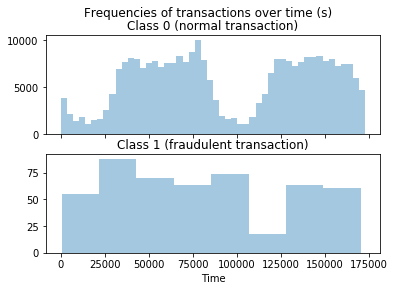

In [4]:
fig, ax = plt.subplots(nrows=2, sharex=True)
plt.suptitle('Frequencies of transactions over time (s)')
sns.distplot(df[df['Class'] == 0]['Time'], ax=ax[0], kde=False)
ax[0].set_xlabel('')
ax[0].set_title('Class 0 (normal transaction)')
sns.distplot(df[df['Class'] == 1]['Time'], ax=ax[1], kde=False)
ax[1].set_title('Class 1 (fraudulent transaction)')

Convert time in seconds to hours. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Class 1 (fraudulent transaction)')

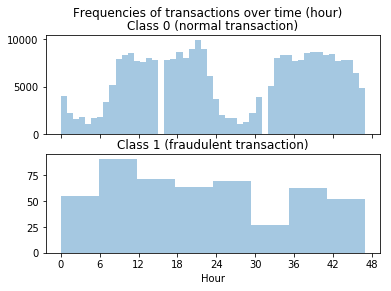

In [5]:
df['Hour'] = np.floor(df['Time']/3600)
fig, ax = plt.subplots(nrows=2, sharex=True)
plt.suptitle('Frequencies of transactions over time (hour)')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(6))
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.distplot(df[df['Class'] == 0]['Hour'], ax=ax[0], kde=False)
ax[0].set_xlabel('')
ax[0].set_title('Class 0 (normal transaction)')
sns.distplot(df[df['Class'] == 1]['Hour'], ax=ax[1], kde=False)
ax[1].set_title('Class 1 (fraudulent transaction)')

Observation: Number of transactions varies with time. We can consider using it as a feature. 

Training anomaly detection methods requires a dataset with all normal instances. 

In [7]:
df_normal = df[df['Class'] == 0]
df_normal_train, df_normal_test = train_test_split(df_normal, test_size=0.33, random_state=0)
df_test = df_normal_test.append(df[df['Class'] == 1])

X_anomaly_train = df_normal_train.drop('Class', axis=1)
X_anomaly_test = df_test.drop('Class', axis=1)
y_anomaly_test = df_test['Class']
del df_normal_train, df_test

For general classification models we split the training and testing datasets the usual way. 
First the datasets without oversampling:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class', 'Time'], axis=1), df['Class'],\
                                                    test_size=0.33, random_state=0)

Now oversample to 1:1:

In [9]:
sm = SMOTE(random_state=0, ratio='auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

## Fit the Models ##

### Isolation Forest ###

In [11]:
clf_if = IsolationForest(max_samples="auto", random_state=0, contamination=0.005) 
clf_if.fit(X_anomaly_train)

IsolationForest(bootstrap=False, contamination=0.005, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)

Merge prediction with true classification. Note that the anomaly score Isolation Forest generates is the lower the more abnormal, so we need to reverse it.

In [13]:
checkresults = y_anomaly_test.to_frame(name='Class').reset_index()\
               .join(pd.DataFrame(clf_if.decision_function(X_anomaly_test), columns=['anomaly_score']))\
               .join(pd.DataFrame(clf_if.predict(X_anomaly_test), columns=['prediction']))

checkresults['reversed_anomaly_score'] = -1 * checkresults['anomaly_score']

Write a function to plot the precision-recall curve. 

In [14]:
def calc_plot_auprc(clf_name, y_score):
    average_precision = average_precision_score(checkresults['Class'], checkresults[y_score], average='samples')

    print('Average precision-recall score for {}: {} in test data'.format(clf_name, average_precision))

    precision, recall, _ = precision_recall_curve(checkresults['Class'], checkresults[y_score])

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

Average precision-recall score for isolation forest: 0.2685240560953985 in test data


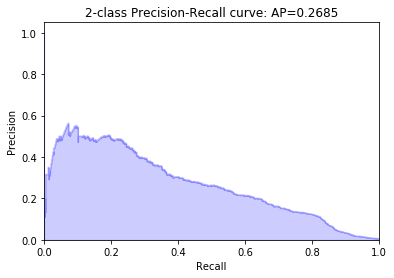

In [15]:
calc_plot_auprc("isolation forest", 'reversed_anomaly_score')

In [16]:
del checkresults

In [17]:
# clf_svm1c = OneClassSVM(random_state=0)
# clf_svm1c.fit(X_normal_train)
# # Takes very long

### Light GBM ###

#### without oversampling ####

In [18]:
clf_lgb = LGBMClassifier(random_state=0)
clf_lgb.fit(X_train, y_train)  

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Training AUPRC: 1.0000
Average precision-recall score for Light GBM: 0.8535459886249628 in test data


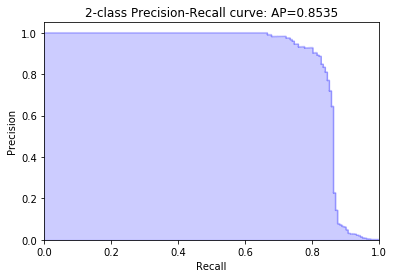

In [19]:
checkresults = y_test.to_frame(name='Class').reset_index()\
               .join(pd.DataFrame(clf_lgb.predict_proba(X_test)[:, 1], columns=['predicted_probability']))\
               .join(pd.DataFrame(clf_lgb.predict_proba(X_test)[:, 1], columns=['prediction']))

print("Training AUPRC: {0:0.4f}"\
      .format(average_precision_score(y_train, clf_lgb.predict_proba(X_train)[:, 1], average='samples')))

calc_plot_auprc("Light GBM", 'predicted_probability')

A perfect precision-recall in training data but 0.85 AUPRC in test data - looks like Light GBM overfits to training data. 

In [20]:
del checkresults

#### with oversampling ####

In [21]:
clf_lgb_oversample = LGBMClassifier(random_state=0)
clf_lgb_oversample.fit(X_train_res, y_train_res)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Training AUPRC: 0.9977
Average precision-recall score for Light GBM (oversampling data): 0.8079545125387172 in test data


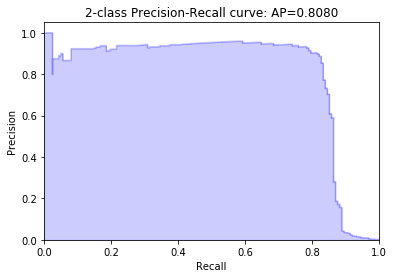

In [22]:
checkresults = y_test.to_frame(name='Class').reset_index()\
               .join(pd.DataFrame(clf_lgb_oversample.predict_proba(X_test)[:, 1], columns=['predicted_probability']))\
               .join(pd.DataFrame(clf_lgb_oversample.predict_proba(X_test)[:, 1], columns=['prediction']))

print("Training AUPRC: {0:0.4f}"\
      .format(average_precision_score(y_train_res, clf_lgb.predict_proba(X_train_res)[:, 1], average='samples')))

calc_plot_auprc("Light GBM (oversampling data)", 'predicted_probability')

Oversampling did not improve the prediction. 

### XGBoost ###

#### without oversampling ####

In [23]:
clf_xgb = XGBClassifier(random_state=0)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Training AUPRC: 0.9180
Average precision-recall score for XGBoost: 0.8481792538035726 in test data


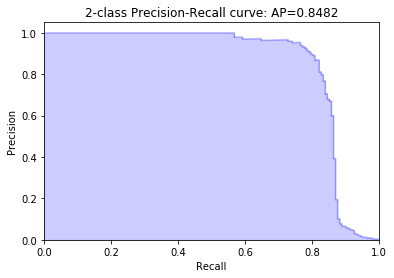

In [24]:
checkresults = y_test.to_frame(name='Class').reset_index()\
               .join(pd.DataFrame(clf_xgb.predict_proba(X_test)[:, 1], columns=['predicted_probability']))\
               .join(pd.DataFrame(clf_xgb.predict_proba(X_test)[:, 1], columns=['prediction']))

print("Training AUPRC: {0:0.4f}"\
      .format(average_precision_score(y_train, clf_xgb.predict_proba(X_train)[:, 1], average='samples')))

calc_plot_auprc("XGBoost", 'predicted_probability')

Oversampling did not lead to any improvement in the Light GBM model so it will not be performed here. 

Final thoughts:
* Isolation Forest does not perform well in identifying credit card fraud. Only default hyperparameters are used in this analysis but I would not expect a substantial change after tuning hyperparameters.
* Oversampling does not improve model performance when class imbalance is extreme. 
* Boosted tree methods tend to overfit but they still have good performance that I would try those methods for future analyses of this type. 